In [33]:
import os
import pickle
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
## set directory to be the directory where the sensitivity analysis results are stored
directory = 'sensitivity_analysis/'
files = [x for x in os.listdir(directory) if 'results' in x]

In [35]:
death_files = [x for x in files if 'death' in x]
reproduction_files = [x for x in files if 'reproduction' in x]
recovery_files = [x for x in files if 'recovery' in x]
sthreshold_files =  [x for x in files if 'sthreshold' in x]

In [36]:
file = sthreshold_files[0]

In [37]:
param = int(file.split('_')[3].strip('p'))
run_number = int(file.split('_')[4].strip('r'))

In [38]:
def parse_files(files):
    results_dict = defaultdict(lambda:0)
    number_runs = defaultdict(lambda:0)
    all_params = []

    for file in files:
        param = int(file.split('_')[3].strip('p'))
        run_number = int(file.split('_')[4].strip('r'))

        with open(directory+file, 'rb') as f:
            result = pickle.load(f)

        results_dict[param] += sum(result['presence_VR'])
        number_runs[param] += 10

        all_params.append((param, run_number))

    results_dict = dict(results_dict)
    
    # check that all runs are present
    length_param_grid = 3
    missing = set(product(range(length_param_grid), range(100))).symmetric_difference(set(all_params))
    if len(missing) == 0:
        print('All runs have been parsed')
    else:
        print('Some runs are missing:', missing)
    
    percentage_takeover = dict(zip(list(results_dict.keys()), [results_dict[p]/number_runs[p] for p in list(results_dict.keys())]))
    confidence_intervals =  dict(zip(list(results_dict.keys()),[1.96*np.sqrt((percentage_takeover[p]*(1-percentage_takeover[p]))/1000) for p in list(results_dict.keys())]))
    
    return([percentage_takeover, confidence_intervals])

In [39]:
death_results, death_ci = parse_files(death_files)
reproduction_results, reproduction_ci = parse_files(reproduction_files)
recovery_results, recovery_ci = parse_files(recovery_files)
sthreshold_results, sthreshold_ci = parse_files(sthreshold_files)

All runs have been parsed
All runs have been parsed
All runs have been parsed
All runs have been parsed


In [44]:
## load paramgrid for sensitivity analysis
with open('sensitivity_analysis/paramgrid_appearance_sensitivity_analysis_sthreshold.txt', 'rb') as f:
    df = pickle.load(f)

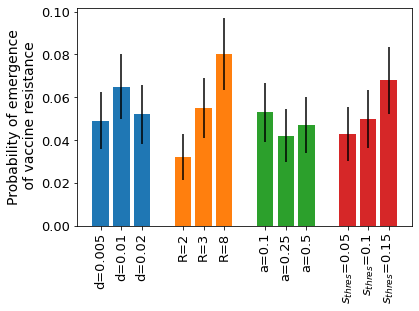

In [46]:
fig, ax = plt.subplots()

ax.bar(np.arange(3), death_results.values(), yerr = death_ci.values())
ax.bar(np.arange(3)+4, reproduction_results.values(), yerr = reproduction_ci.values())
ax.bar(np.arange(3)+8, recovery_results.values(), yerr = recovery_ci.values())
ax.bar(np.arange(3)+12, sthreshold_results.values(), yerr = sthreshold_ci.values())

ax.set_xticks(list(np.arange(3)) + list(np.arange(3)+4) + list(np.arange(3)+8) + list(np.arange(3)+12))

ax.set_xticklabels(['d='+str(d) for d in [0.005,0.01,0.02]] + ['R='+str(R) for R in [2,3,8]]
                   + ['a='+str(a) for a in [0.1,0.25,0.5]] + ['$s_{thres}$='+str(s) for s in [0.05,0.1,0.15]], rotation = 90,
                  fontsize = 13)

ax.tick_params(axis='both', labelsize = 13)

ax.set_ylabel('Probability of emergence\n of vaccine resistance', fontsize = 14)
plt.savefig('Sensitivity_Analysis_final.jpg', dpi = 400, bbox_inches = 'tight')
plt.show()